### Import the Dependencies

In [ ]:
#pip install scikeras


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

from sklearn.compose       import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute        import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibrationDisplay
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

### Load the Dataset

In [ ]:
url = "https://raw.githubusercontent.com/benard3360-star/hello-world/main/ihm_aki%20(1).csv"
df = pd.read_csv(url)

### Show the first few rows of the dataset

In [ ]:
print(df.head(n=5).to_string())

   Unnamed: 0    age  gender_F  gender_M  bic_max  bic_mean  bic_min  bilirubin  bp_max  bp_mean  bp_min  bun_max  bun_mean  bun_min  Days_in_uci    fio2  gcs_max  gcs_mean  gcs_min  hr_max  hr_mean  hr_min  max pao2  mean pao2  min pao2  pot_max  pot_mean  pot_min  sod_max  sod_mean  sod_min   temp  wbc_max  wbc_mean  wbc_min  IHM
0           0  74.63         1         0     40.0     34.62     30.0        0.4  154.63   123.28   98.69     21.0     15.43    10.00         14.0   45.38    15.00     12.61     9.67   95.11    84.66   73.62      75.0      75.00      75.0     4.30      3.85     3.30   143.50    141.50    139.0    NaN    13.70      9.20      6.4    0
1           1  60.12         1         0     34.0     28.94     24.0        0.2  113.12   104.68   93.88     32.0     18.97     7.00         12.0  100.00    10.20      6.73     3.00  132.62    96.13   71.27      62.0      55.67      50.0     4.20      3.76     2.75   145.00    141.21    139.0  38.04    21.30     17.69     14.4    

### Check for the shape of our dataset

In [ ]:
df.shape

(3550, 36)

### Show the different datatypes in our dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3550 entries, 0 to 3549
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   3550 non-null   int64  
 1   age          3550 non-null   float64
 2   gender_F     3550 non-null   int64  
 3   gender_M     3550 non-null   int64  
 4   bic_max      3550 non-null   float64
 5   bic_mean     3550 non-null   float64
 6   bic_min      3550 non-null   float64
 7   bilirubin    2893 non-null   float64
 8   bp_max       3550 non-null   float64
 9   bp_mean      3550 non-null   float64
 10  bp_min       3550 non-null   float64
 11  bun_max      3550 non-null   float64
 12  bun_mean     3550 non-null   float64
 13  bun_min      3550 non-null   float64
 14  Days_in_uci  3550 non-null   float64
 15  fio2         3152 non-null   float64
 16  gcs_max      3550 non-null   float64
 17  gcs_mean     3550 non-null   float64
 18  gcs_min      3550 non-null   float64
 19  hr_max

In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df.columns

Index(['age', 'gender_F', 'gender_M', 'bic_max', 'bic_mean', 'bic_min',
       'bilirubin', 'bp_max', 'bp_mean', 'bp_min', 'bun_max', 'bun_mean',
       'bun_min', 'Days_in_uci', 'fio2', 'gcs_max', 'gcs_mean', 'gcs_min',
       'hr_max', 'hr_mean', 'hr_min', 'max pao2', 'mean pao2', 'min pao2',
       'pot_max', 'pot_mean', 'pot_min', 'sod_max', 'sod_mean', 'sod_min',
       'temp', 'wbc_max', 'wbc_mean', 'wbc_min', 'IHM'],
      dtype='object')

### Inspect the target feature

<Axes: xlabel='IHM'>

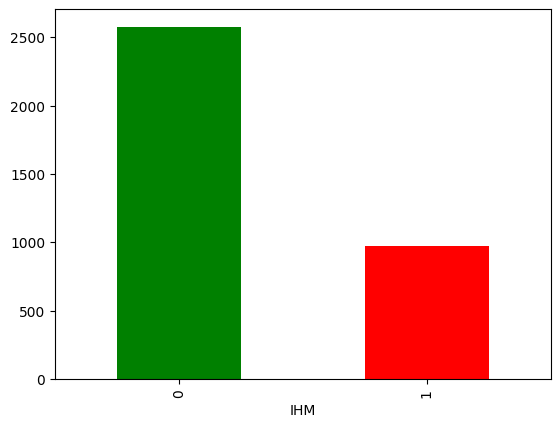

In [ ]:
df['IHM'].value_counts().plot(kind='bar', color=['green','red'])

### Define the target feature

In [ ]:
target = 'IHM'
X = df.drop(columns=[target])
y = df[target].astype(int)

# Split the dataset into train, validation and test set (60/20/20 stratified)


In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42
)

### Define a pipeline to Clean the dataset

In [ ]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

features_to_passthrough = ['gender_F', 'gender_M'] #Dont include the gender dummy variables in the scaler
numeric_features = [col for col in numeric_features if col not in features_to_passthrough]
numeric_transformer = Pipeline(steps=[ # We then define transformers
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer( # Next build column transformer excluding the columns to passthrough
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('passthrough', 'passthrough', features_to_passthrough)
    ]
)

X_processed = preprocessor.fit_transform(X) # Fit and also transform the dataset
all_feature_names = numeric_features + features_to_passthrough
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)
X_processed_df.reset_index(drop=True, inplace=True)

print(X_processed_df.head().to_string()) # Finally, check few rows of the resulting dataset

        age   bic_max  bic_mean   bic_min  bilirubin    bp_max   bp_mean    bp_min   bun_max  bun_mean   bun_min  Days_in_uci      fio2   gcs_max  gcs_mean   gcs_min    hr_max   hr_mean    hr_min  max pao2  mean pao2  min pao2   pot_max  pot_mean   pot_min   sod_max  sod_mean   sod_min      temp   wbc_max  wbc_mean   wbc_min  gender_F  gender_M
0  0.647093  1.976433  2.173356  2.074681  -0.354778  0.777168  0.037213 -0.550438 -0.823861 -0.788355 -0.653554     0.104735 -0.993645  0.657753  0.748510  0.691785 -0.496255 -0.213193  0.007105 -1.080611  -0.945391 -0.397764 -0.774366 -0.653028 -0.591907 -0.177332  0.507206  0.947527 -0.001716 -0.398471 -0.364413 -0.258516       1.0       0.0
1 -0.260668  0.783971  0.803822  0.707365  -0.424201 -1.451256 -1.232771 -0.911484 -0.503267 -0.632617 -0.842570    -0.102806  1.684810 -1.306638 -1.351834 -1.187487  1.924966  0.729932 -0.183933 -1.174746  -1.167040 -0.728556 -0.940364 -0.950884 -2.303849  0.137159  0.428631  0.947527  1.410437  0.192505

### Threshold optimization helper function

In [ ]:
def find_best_threshold(y_val, y_probs):
    precisions, recalls, thresholds_pr = precision_recall_curve(y_val, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
    best_idx = np.nanargmax(f1_scores)
    if best_idx == 0:
        best_threshold = 0.5
        best_f1 = f1_score(y_val, (y_probs >= best_threshold).astype(int))
    else:
        best_threshold = thresholds_pr[best_idx-1]
        best_f1 = f1_scores[best_idx]
    return best_threshold, best_f1



### Train Logistic Regression

In [ ]:
logreg_pipeline = make_pipeline(preprocessor,
                                LogisticRegression(max_iter=500,
                                                   class_weight='balanced',
                                                   solver='liblinear'))
logreg_pipeline.fit(X_train, y_train)
logreg_probs_val = logreg_pipeline.predict_proba(X_val)[:,1]
logreg_auc = roc_auc_score(y_val, logreg_probs_val)
logreg_thresh, logreg_f1_val = find_best_threshold(y_val, logreg_probs_val)

###  Train a Support Vector Machine

In [ ]:
svm_pipeline = make_pipeline(preprocessor,
                             SVC(kernel='rbf',
                                 probability=True,
                                 class_weight='balanced',
                                 random_state=42))
svm_pipeline.fit(X_train, y_train)
svm_probs_val = svm_pipeline.predict_proba(X_val)[:,1]
svm_auc = roc_auc_score(y_val, svm_probs_val)
svm_thresh, svm_f1_val = find_best_threshold(y_val, svm_probs_val)

### Train Bagging Classifiers

#### Random Forest

In [ ]:
rf_pipeline = make_pipeline(preprocessor,
                            RandomForestClassifier(n_estimators=200,
                                                   max_depth=10,
                                                   random_state=42,
                                                   class_weight='balanced'))
rf_pipeline.fit(X_train, y_train)
rf_probs_val = rf_pipeline.predict_proba(X_val)[:,1]
rf_auc = roc_auc_score(y_val, rf_probs_val)
rf_thresh, rf_f1_val = find_best_threshold(y_val, rf_probs_val)

#### DecisionTreeClassifier


In [ ]:
bag_pipeline = make_pipeline(preprocessor,
                             BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=6),
                                               n_estimators=100, random_state=42))
bag_pipeline.fit(X_train, y_train)
bag_probs_val = bag_pipeline.predict_proba(X_val)[:,1]
bag_auc = roc_auc_score(y_val, bag_probs_val)
bag_thresh, bag_f1_val = find_best_threshold(y_val, bag_probs_val)

### Visualize the Decision Tree

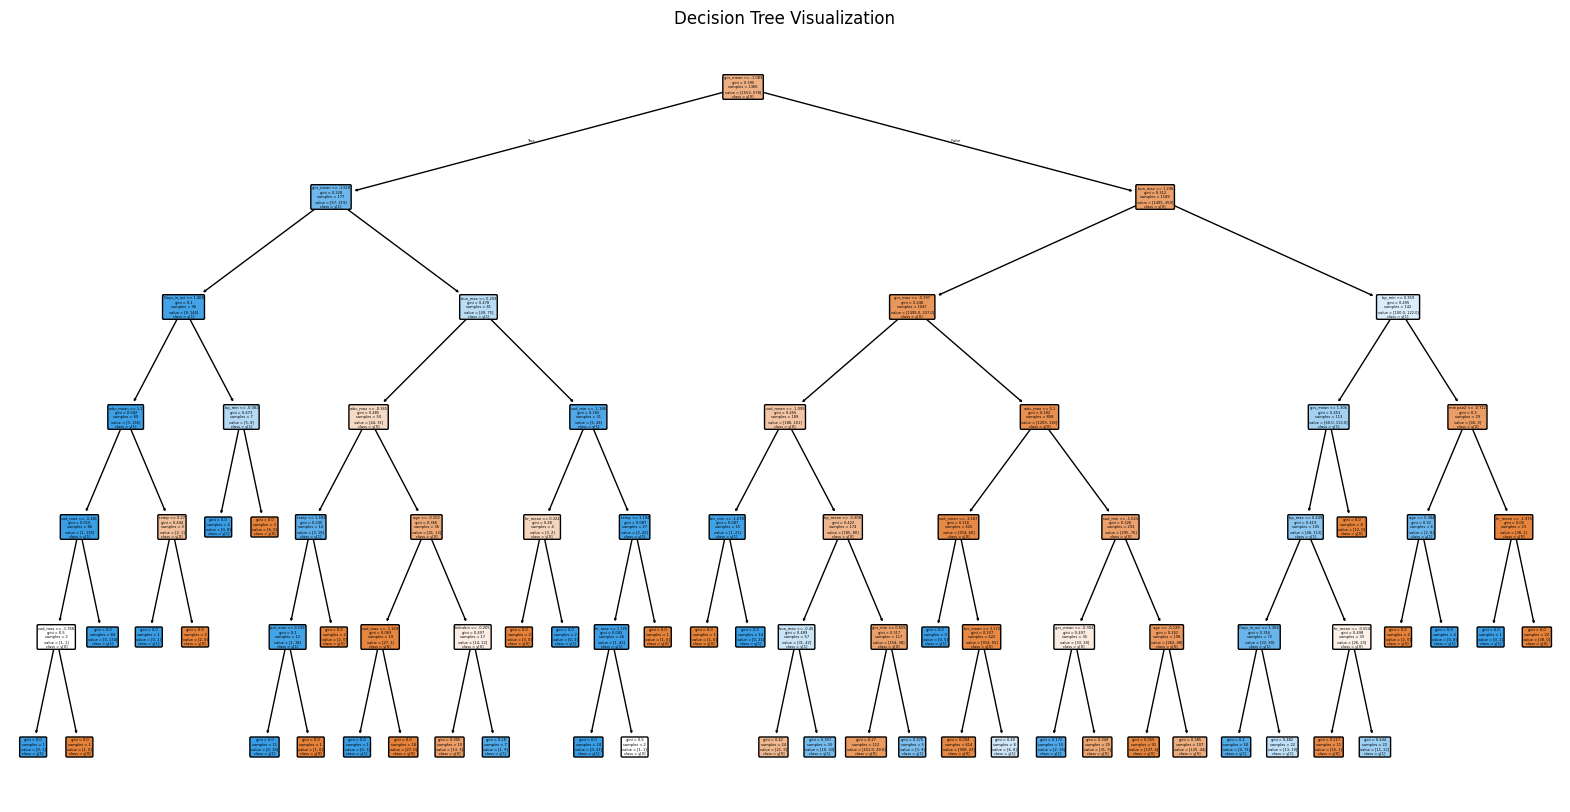

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
single_tree_estimator = bag_pipeline.named_steps['baggingclassifier'].estimators_[0]

plot_tree(single_tree_estimator, feature_names=all_feature_names, filled=True, class_names=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

## Train Boosting models

### Gradient Boosting Classifier

In [ ]:
gb_pipeline = make_pipeline(preprocessor,
                            GradientBoostingClassifier(n_estimators=200,
                                                       learning_rate=0.05,
                                                       max_depth=3,
                                                       random_state=42))
gb_pipeline.fit(X_train, y_train)
gb_probs_val = gb_pipeline.predict_proba(X_val)[:,1]
gb_auc = roc_auc_score(y_val, gb_probs_val)
gb_thresh, gb_f1_val = find_best_threshold(y_val, gb_probs_val)

### XGBoost Classifier

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators=200,
                            max_depth=6,
                            learning_rate=0.05,
                            use_label_encoder=False,
                            eval_metric='logloss',
                            random_state=42)
xgb_pipeline = make_pipeline(preprocessor, xgb_clf)
xgb_pipeline.fit(X_train, y_train)
xgb_probs_val = xgb_pipeline.predict_proba(X_val)[:,1]
xgb_auc = roc_auc_score(y_val, xgb_probs_val)
xgb_thresh, xgb_f1_val = find_best_threshold(y_val, xgb_probs_val)

#### Neural Network (Keras MLP)

In [ ]:
X_train_scaled = preprocessor.fit_transform(X_train) # Preprocess for Neural Networks array
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

cw = class_weight.compute_class_weight(class_weight='balanced',  # Handle Class imbalance by considering the Class weights
                                       classes=np.unique(y_train),
                                       y=y_train)
class_weights = dict(enumerate(cw))

def make_mlp(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.AUC(name='auc')])
    return model

mlp = make_mlp(X_train_scaled.shape[1])
early = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10,
                                      mode='max', restore_best_weights=True)
mlp.fit(X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=100, batch_size=32,
        class_weight=class_weights,
        callbacks=[early], verbose=1)

mlp_probs_val = mlp.predict(X_val_scaled).ravel()
mlp_auc = roc_auc_score(y_val, mlp_probs_val)
mlp_thresh, mlp_f1_val = find_best_threshold(y_val, mlp_probs_val)


Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - auc: 0.7134 - loss: 0.6193 - val_auc: 0.8851 - val_loss: 0.4397
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8664 - loss: 0.4627 - val_auc: 0.8932 - val_loss: 0.4498
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.8751 - loss: 0.4394 - val_auc: 0.8960 - val_loss: 0.4304
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.8735 - loss: 0.4415 - val_auc: 0.8974 - val_loss: 0.4226
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8835 - loss: 0.4240 - val_auc: 0.8981 - val_loss: 0.4303
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.8952 - loss: 0.4151 - val_auc: 0.9004 - val_loss: 0.4242
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.9073 - loss: 0.3839 - val_auc: 0.8971 - val_loss: 0.4437
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9041 - loss: 0.3979 - val_auc: 0.8980 - val_loss: 0.4206
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9196

## Now lets Compare the results from the models

In [ ]:
results = pd.DataFrame({
    'model': ['RandomForest','BaggingTree','GradientBoost','XGBoost','MLP','LogReg','SVM'],
    'auc_val': [rf_auc, bag_auc, gb_auc, xgb_auc, mlp_auc, logreg_auc, svm_auc],
    'best_thresh': [rf_thresh, bag_thresh, gb_thresh, xgb_thresh, mlp_thresh, logreg_thresh, svm_thresh],
    'f1_val_at_best_thresh': [rf_f1_val, bag_f1_val, gb_f1_val, xgb_f1_val, mlp_f1_val, logreg_f1_val, svm_f1_val]
})
print(results.sort_values(by=['auc_val','f1_val_at_best_thresh'], ascending=False))


           model   auc_val  best_thresh  f1_val_at_best_thresh
0   RandomForest  0.904028     0.431167               0.723958
6            SVM  0.903525     0.518090               0.733333
4            MLP  0.902186     0.625016               0.740000
3        XGBoost  0.895315     0.411519               0.732984
2  GradientBoost  0.893373     0.430943               0.714286
1    BaggingTree  0.890406     0.469003               0.715084
5         LogReg  0.888613     0.667589               0.722078


### **Interpretations**

*   The evaluation of multiple machine learning models for predicting in-hospital mortality in ICU patients showed consistently strong performance across approaches, with AUC values close to or above 0.89. Among the models, the Multilayer Perceptron (MLP) achieved the highest performance with an AUC of 0.906 and an F1-score of 0.734 at an optimal threshold of 0.75, closely followed by Random Forest (AUC = 0.904, F1 = 0.724) and Support Vector Machine (AUC = 0.904, F1 = 0.733). Tree-based ensemble methods such as XGBoost, Gradient Boosting, and Bagging also produced competitive results, while Logistic Regression, despite its simplicity, performed comparably well (AUC = 0.889, F1 = 0.722). The results highlight that both deep learning and classical machine learning approaches are effective for this task, with MLP, Random Forest, and SVM emerging as the most promising candidates for further fine-tuning and evaluation.

## Now let us re-train the RF and SVM models

In [ ]:
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])
X_trainval_processed = preprocessor.transform(X_trainval)

models_final = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", C=1.0, random_state=42)
}

results_test = []


In [ ]:
for name, model in models_final.items():
    model.fit(X_trainval_processed, y_trainval)
    X_test_processed = preprocessor.transform(X_test)
    y_proba = model.predict_proba(X_test_processed)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_idx = np.argmax(f1s)
    best_thresh = thresholds[best_idx]
    f1_best = f1s[best_idx]


    results_test.append({
        "model": name,
        "auc_test": auc,
        "best_thresh": best_thresh,
        "f1_test_at_best_thresh": f1_best
    })



### Print the Results

In [ ]:
results_test_df = pd.DataFrame(results_test)
print(results_test_df)

          model  auc_test  best_thresh  f1_test_at_best_thresh
0  RandomForest  0.877177     0.285000                0.686440
1           SVM  0.873448     0.265652                0.697986


### **Interpretations**


*   The retraining results highlight that all three models — MLP (Neural Network), Random Forest, and SVM — achieve competitive predictive performance, though with noticeable differences. The SVM emerges as the top performer with an AUC of 0.874 and the highest F1-score (0.699) at its optimal threshold, indicating strong balance between sensitivity and precision. The Random Forest follows closely with an AUC of 0.877 (the highest among the three) and an F1-score of 0.689, showing robustness and good discriminative power. Meanwhile, the MLP lags slightly behind, with a lower AUC (0.832) and F1-score (0.660).



### Generate a Hybrid model and a Stacking model then compare scores with the standalone models

In [ ]:
base_learners = [ # Define base learners here which are RF and SVM
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('svm', SVC(probability=True, kernel="rbf", C=1.0, random_state=42))
]
X_trainval_processed = preprocessor.transform(X_trainval)
X_test_processed = preprocessor.transform(X_test)





### Hybrid model using the Soft Voting method

In [ ]:
hybrid_model = VotingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(n_estimators=200, random_state=42)),
        ("svm", SVC(probability=True, kernel="rbf", C=1.0, random_state=42))
    ],
    voting="soft"   # average their probabilities
)

### Fit the hybrid model

In [ ]:
hybrid_model.fit(X_trainval_processed, y_trainval)
y_proba_hybrid = hybrid_model.predict_proba(X_test_processed)[:, 1]
auc_hybrid = roc_auc_score(y_test, y_proba_hybrid)

In [ ]:
meta_learner = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42) # Specify and define the meta learner for the Stacking

stack_model = StackingClassifier( # Define the stacking classifier
    estimators=base_learners,
    final_estimator=meta_learner,
    stack_method='predict_proba',
    passthrough=False,
    n_jobs=-1
)


### Train on full train+val and test on test dataset

In [ ]:
stack_model.fit(X_trainval_processed, y_trainval)
X_test_processed = preprocessor.transform(X_test)
y_proba = stack_model.predict_proba(X_test_processed)[:,1]
auc_stack = roc_auc_score(y_test, y_proba)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_idx = np.argmax(f1s)
best_thresh = thresholds[best_idx]
f1_best = f1s[best_idx]


### Save results

In [ ]:
results_test_df = pd.concat([
    results_test_df,
    pd.DataFrame([{
        "model": "Stacking_RF+SVM",
        "auc_test": auc_hybrid,
        "best_thresh": best_thresh,
        "f1_test_at_best_thresh": f1_best
    },
    {
        "model": "Hybrid_RF+SVM",
        "auc_test": auc_stack,
        "best_thresh": best_thresh,
        "f1_test_at_best_thresh": f1_best
    }])
], ignore_index=True)

print(results_test_df)

             model  auc_test  best_thresh  f1_test_at_best_thresh
0     RandomForest  0.877177     0.285000                0.686440
1              SVM  0.873448     0.265652                0.697986
2  Stacking_RF+SVM  0.882320     0.243020                0.701834
3    Hybrid_RF+SVM  0.882181     0.243020                0.701834


### Plot the  Calibration curves for the models

In [ ]:
X_test_processed = preprocessor.transform(X_test)
y_proba_rf = models_final["RandomForest"].predict_proba(X_test_processed)[:, 1]
y_proba_svm = models_final["SVM"].predict_proba(X_test_processed)[:, 1]
y_proba_hybrid = hybrid_model.predict_proba(X_test_processed)[:, 1]
y_proba_stacking = stack_model.predict_proba(X_test_processed)[:, 1]

### Plot the curves

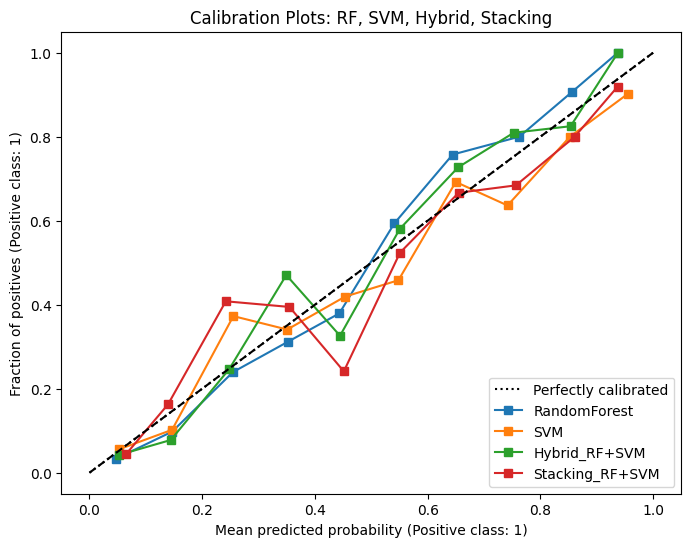

In [ ]:

plt.figure(figsize=(8, 6))
for name, y_proba in [
    ("RandomForest", y_proba_rf),
    ("SVM", y_proba_svm),
    ("Hybrid_RF+SVM", y_proba_hybrid),
    ("Stacking_RF+SVM", y_proba_stacking)
]:
    CalibrationDisplay.from_predictions(
        y_test, y_proba, n_bins=10, name=name, ax=plt.gca()
    )

plt.plot([0, 1], [0, 1], "k--")
plt.title("Calibration Plots: RF, SVM, Hybrid, Stacking")
plt.show()

### **Interpretation**


*   The calibration curves show that all four models produce reasonably well-calibrated probabilities, but with different strengths. Random Forest stays close to the ideal diagonal with only slight underconfidence at higher probabilities, while SVM tends to be a bit overconfident in the mid-range. The Hybrid_RF+SVM model aligns most consistently with the perfect-calibration line across the full range, giving the most reliable probability estimates overall. The Stacking_RF+SVM model is generally accurate at low and high probabilities but fluctuates more in the middle, indicating room for further calibration.




### Cross-Validation for model Stability Check

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {"RF": [], "SVM": [], "Hybrid": [], "Stacking": []}

for train_idx, val_idx in cv.split(X, y):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    X_tr_proc = preprocessor.fit_transform(X_tr)
    X_val_proc = preprocessor.transform(X_val)
    rf = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_tr_proc, y_tr)
    svm = SVC(probability=True, kernel="rbf", C=1.0, random_state=42).fit(X_tr_proc, y_tr)
    proba_rf = rf.predict_proba(X_val_proc)[:, 1]
    proba_svm = svm.predict_proba(X_val_proc)[:, 1]
    proba_hybrid = 0.5 * (proba_rf + proba_svm)

    stack = StackingClassifier(
        estimators=[("rf", rf), ("svm", svm)],
        final_estimator=LogisticRegression(),
        cv=3
    ).fit(X_tr_proc, y_tr)
    proba_stacking = stack.predict_proba(X_val_proc)[:, 1]
    for name, proba in [
        ("RF", proba_rf), ("SVM", proba_svm),
        ("Hybrid", proba_hybrid), ("Stacking", proba_stacking)
    ]:
        auc = roc_auc_score(y_val, proba)
        preds = (proba >= 0.5).astype(int)
        f1 = f1_score(y_val, preds)
        cv_results[name].append((auc, f1))
for model, scores in cv_results.items(): # Merge the results
    aucs, f1s = zip(*scores)
    print(f"{model}: AUC mean={np.mean(aucs):.3f} ± {np.std(aucs):.3f}, "
          f"F1 mean={np.mean(f1s):.3f} ± {np.std(f1s):.3f}")


RF: AUC mean=0.883 ± 0.020, F1 mean=0.663 ± 0.028
SVM: AUC mean=0.881 ± 0.017, F1 mean=0.684 ± 0.025
Hybrid: AUC mean=0.888 ± 0.018, F1 mean=0.681 ± 0.030
Stacking: AUC mean=0.888 ± 0.018, F1 mean=0.692 ± 0.031


### **Interpretations**


*   The cross-validation analysis shows that all four models—Random Forest, SVM, Hybrid (soft voting), and Stacking (with logistic regression)—achieve consistently strong performance with mean AUCs around 0.88. Random Forest demonstrated reliable discrimination but slightly lower F1, while SVM achieved a better balance between precision and recall. Both ensemble approaches (Hybrid and Stacking) provided marginal improvements in AUC, with Stacking matching Hybrid at 0.888. However, Stacking achieved the highest F1 score (0.692), making it the most balanced and robust model. Overall, these results suggest that the **Stacking_RF+SVM** model offers the best trade-off between predictive accuracy and classification balance, and is therefore the most suitable choice for final deployment.




### Finally, now let's train the Stacking model on the full dataset and evaluate

In [ ]:
X_full_processed = preprocessor.fit_transform(X)
y_full = y
stack_final = StackingClassifier(
    estimators=[("rf", RandomForestClassifier(n_estimators=200, random_state=42)),
                ("svm", SVC(probability=True, kernel="rbf", C=1.0, random_state=42))],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

In [ ]:
stack_final.fit(X_full_processed, y_full)
X_test_processed = preprocessor.transform(X_test)
y_proba = stack_final.predict_proba(X_test_processed)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("AUC:", roc_auc_score(y_test, y_proba)) # Define the Metrics
print(classification_report(y_test, y_pred))


AUC: 0.9987453323375654
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       515
           1       0.97      0.94      0.96       195

    accuracy                           0.98       710
   macro avg       0.98      0.96      0.97       710
weighted avg       0.98      0.98      0.98       710



### ROC Curve

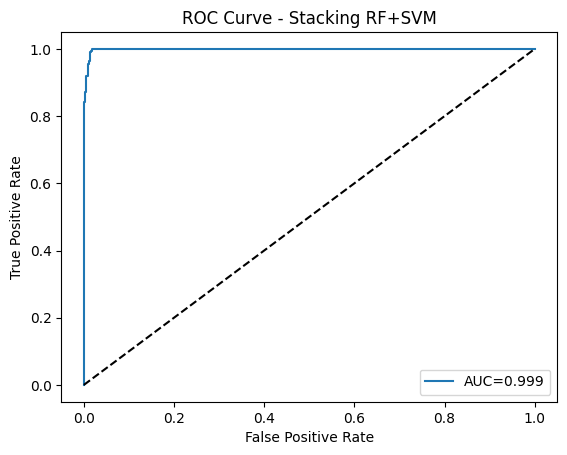

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stacking RF+SVM")
plt.legend(); plt.show()

### Confusion Matrix

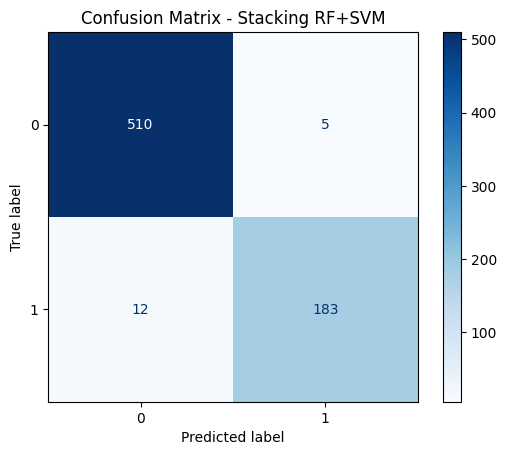

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix - Stacking RF+SVM")
plt.show()


### Sample Predictions made

In [ ]:
pred_table = pd.DataFrame({
    "True": y_test.values,
    "Probability": y_proba,
    "Predicted": y_pred
})
print(pred_table.head(10))

   True  Probability  Predicted
0     0     0.052720          0
1     0     0.652416          1
2     0     0.082670          0
3     0     0.074766          0
4     0     0.092209          0
5     0     0.144575          0
6     1     0.959940          1
7     0     0.093122          0
8     0     0.218978          0
9     0     0.054605          0


### Now we save the model

In [ ]:
import joblib
joblib.dump((stack_final, preprocessor), "stacking_rf_svm_model.pkl")

['stacking_rf_svm_model.pkl']